In [ ]:
import requests
from bs4 import BeautifulSoup
import csv

def scrape_wikiart_names(artist_url):
    url = f"https://www.wikiart.org/en/{artist_url}/all-works/text-list"
    response = requests.get(url)

    soup = BeautifulSoup(response.text, 'html.parser')
    paintings = soup.find_all('li', class_='painting-list-text-row')

    # Abrir el archivo en modo "agregar" ('a') para no sobrescribir los datos existentes
    with open('paintings.csv', mode='a', newline='') as file:
        writer = csv.writer(file)

        # Verificar si el archivo está vacío para escribir el encabezado solo una vez
        if file.tell() == 0:
            writer.writerow(["Painting Name", "URL"])  # Encabezados solo si el archivo está vacío

        for painting in paintings:
            painting_name = painting.find('a').text.strip()  # Obtener el nombre de la obra y quitar espacios en blanco
            img_page = painting.find('a')['href']
            writer.writerow([painting_name, f"https://www.wikiart.org{img_page}"])
            print(f"Obra: {painting_name}")

# Ejemplo para obtener los datos de las obras de varios artistas
scrape_wikiart_names("vincent-van-gogh")

Obra: The Goat Herd
Obra: Dog
Obra: Milk Jug
Obra: Barn and Farmhouse
Obra: Two Sketches of a Man Leaning on His Spade
Obra: Old Woman Asleep after Rops
Obra: Vincent's Boarding House in Hackford Road, Brixton, London
Obra: Driveway
Obra: Canal
Obra: Austin Friars Church, London
Obra: Town d'Avray: L'Etang au Batelier
Obra: Vicarage and Church at Etten
Obra: Vicarage at Etten
Obra: View of Royal Road, Ramsgate
Obra: View of Royal Road, Ramsgate
Obra: Churches at Petersham and Turnham Green
Obra: Mills in the Neighbourhood of Dordrecht
Obra: The Cave of Machpelah
Obra: “Au Charbonnage” Café
Obra: A house Magros
Obra: A Zandmennik house
Obra: Coal Shoveler
Obra: Coalmine in the Borinage
Obra: Miners
Obra: Miners in the Snow at Dawn
Obra: The Angelus (after Millet)
Obra: A Digger
Obra: A Girl Raking
Obra: A Man with a Broom
Obra: A Marsh
Obra: An Old Man Putting Dry Rice on the Hearth
Obra: Barn with Moss-Covered Roof
Obra: Boy Cutting Grass with a Sickle
Obra: Daughter of Jacob Meyer
Obr

In [ ]:
import os
import pandas as pd
import requests
from concurrent.futures import ThreadPoolExecutor
from bs4 import BeautifulSoup

# Lee el archivo CSV
df = pd.read_csv('paintings.csv')

# Crear la carpeta principal 'wikiart_images' si no existe
save_dir = 'dataset'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Función para obtener la URL de la imagen
def get_image_url(page_url):
    try:
        response = requests.get(page_url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            img_tag = soup.find('img', itemprop='image')
            if img_tag and 'src' in img_tag.attrs:
                return img_tag['src'].replace(':large', '')
        else:
            print(f"Error al acceder a {page_url}: {response.status_code}")
    except Exception as e:
        print(f"Error al acceder a {page_url}: {e}")
    return None

# Función para descargar imágenes
def download_image(row):
    # Obtener el nombre del autor y de la obra
    #author = row['Author'].replace(' ', '_').replace('/', '_')  # Limpiar el nombre del autor
    painting_name = row['Painting Name'].replace(' ', '_').replace('/', '_')  # Limpiar el nombre de la obra

    # Crear una carpeta para el autor dentro de 'wikiart_images'
    original_dir = os.path.join(save_dir, 'original_images')
    os.makedirs(original_dir, exist_ok=True)  # Esto asegura que no haya error si la carpeta ya existe (Sirve para un entorno con múltiple hilos)

    # Obtener la URL de la imagen
    image_url = get_image_url(row['URL'])
    if image_url:  # Verifica que la URL de la imagen no sea None
        # Generar el nombre del archivo usando el nombre de la obra
        image_name = f"{painting_name}_original.jpg"

        try:
            response = requests.get(image_url)
            if response.status_code == 200:
                # Guardar la imagen en la carpeta del autor
                with open(os.path.join(original_dir, image_name), 'wb') as f:
                    f.write(response.content)
                print(f"Descargada: {os.path.join(original_dir, image_name)}")
            else:
                print(f"Error al descargar {image_name}: {response.status_code}")
        except Exception as e:
            print(f"Error al descargar {image_name}: {e}")
    else:
        print(f"No se pudo obtener la URL de la imagen para {painting_name}")

# Descargar las imágenes usando múltiples hilos
with ThreadPoolExecutor(max_workers=10) as executor:  # max_workers determina cuántas descargas en paralelo
    # Pasar cada fila del DataFrame para la descarga
    futures = [executor.submit(download_image, row) for _, row in df.iterrows()]

    # Verificar la finalización de las tareas
    for future in futures:
        future.result()

Descargada: dataset/original_images/Barn_and_Farmhouse_original.jpg
Descargada: dataset/original_images/Two_Sketches_of_a_Man_Leaning_on_His_Spade_original.jpg
Descargada: dataset/original_images/Milk_Jug_original.jpg
Descargada: dataset/original_images/The_Goat_Herd_original.jpg
Descargada: dataset/original_images/Dog_original.jpg
Descargada: dataset/original_images/Old_Woman_Asleep_after_Rops_original.jpg
Descargada: dataset/original_images/Vincent's_Boarding_House_in_Hackford_Road,_Brixton,_London_original.jpg
Descargada: dataset/original_images/Austin_Friars_Church,_London_original.jpg
Descargada: dataset/original_images/Canal_original.jpg
Descargada: dataset/original_images/Driveway_original.jpg
Descargada: dataset/original_images/View_of_Royal_Road,_Ramsgate_original.jpg
Descargada: dataset/original_images/Town_d'Avray:_L'Etang_au_Batelier_original.jpg
Descargada: dataset/original_images/Vicarage_and_Church_at_Etten_original.jpg
Descargada: dataset/original_images/Vicarage_at_Ett

In [ ]:
# Eliminar la carpeta degraded_images
!rm -r dataset/degraded_images

In [ ]:
import os
import numpy as np
import random
import cv2  # Necesitas OpenCV para desenfoque
from PIL import Image

# Rutas de los directorios
original_images_dir = '/content/dataset/original_images'
degraded_images_dir = '/content/dataset/degraded_images'
crack_textures_dir = '/content/crack_textures'

# Crear la carpeta degraded_images si no existe
if not os.path.exists(degraded_images_dir):
    os.makedirs(degraded_images_dir)

# Obtener la lista de texturas de grietas disponibles
crack_textures = [os.path.join(crack_textures_dir, f) for f in os.listdir(crack_textures_dir) if f.endswith('.png')]

# Función para agregar ruido a una imagen
def add_noise(image, noise_factor=0.3):
    image = np.array(image) / 255.0
    noise = np.random.normal(0, noise_factor, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    return (noisy_image * 255).astype(np.uint8)

# Función para aplicar desenfoque
def apply_blur(image, blur_strength=5):
    image = np.array(image)
    blurred_image = cv2.GaussianBlur(image, (blur_strength, blur_strength), 0)
    return blurred_image

# Función para desvanecer colores de forma aleatoria
def fade_colors(image, min_fade=0.0, max_fade=0.7, prob_no_fade=0.3):
    # Decidir aleatoriamente si se aplica el desvanecimiento o no
    if random.random() < prob_no_fade:
        return np.array(image)  # Devolver la imagen original sin desvanecimiento

    # Si se aplica, generar un factor de desvanecimiento aleatorio
    fade_factor = random.uniform(min_fade, max_fade)
    image = np.array(image) / 255.0
    faded_image = image * fade_factor + (1 - fade_factor) * np.mean(image, axis=2, keepdims=True)
    faded_image = np.clip(faded_image, 0, 1)
    return (faded_image * 255).astype(np.uint8)

# Función para aplicar grietas usando una textura aleatoria
def apply_crack_texture(image, alpha=0.5):
    # Seleccionar aleatoriamente una textura de grietas
    crack_texture_path = random.choice(crack_textures)
    # Leer la textura y aplicar
    image = image.convert('RGBA')  # Convertimos la imagen a RGBA para trabajar con transparencias
    crack_texture = Image.open(crack_texture_path).convert('RGBA')
    crack_texture = crack_texture.resize(image.size)  # Ajustar tamaño de textura a la imagen
    blended_image = Image.blend(image, crack_texture, alpha=alpha)
    return blended_image.convert('RGB')  # Convertimos de vuelta a RGB para guardar

# Procesar todas las imágenes en la carpeta original_images
for filename in os.listdir(original_images_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        # Leer la imagen original
        image_path = os.path.join(original_images_dir, filename)
        original_image = Image.open(image_path)

        # Convertir la imagen a modo RGB si es RGBA
        if original_image.mode == 'RGBA':
            original_image = original_image.convert('RGB')

        # Generar la imagen degradada (Ruido)
        degraded_image = add_noise(original_image, noise_factor=0.1)

        # Aplicar desenfoque
        degraded_image = apply_blur(degraded_image, blur_strength=5)

        # Aplicar desvanecimiento de colores de forma aleatoria
        degraded_image = fade_colors(degraded_image, min_fade=0.3, max_fade=0.7, prob_no_fade=0.3)

        # Aplicar textura de grietas aleatoria
        degraded_image = apply_crack_texture(Image.fromarray(degraded_image), alpha=0.2)

        # Eliminar "_original" del nombre del archivo y añadir "_degraded"
        base_filename = os.path.splitext(filename)[0].replace('_original', '')
        degraded_image_filename = base_filename + '_degraded.jpg'
        degraded_image_path = os.path.join(degraded_images_dir, degraded_image_filename)

        # Guardar la imagen degradada en formato JPEG
        Image.fromarray(np.array(degraded_image)).save(degraded_image_path, 'JPEG')

print("Las imágenes degradadas se han guardado en la carpeta 'degraded_images' con texturas de grietas y desvanecimiento de colores aleatorio.")

Las imágenes degradadas se han guardado en la carpeta 'degraded_images' con texturas de grietas y desvanecimiento de colores aleatorio.


In [ ]:
import shutil
from google.colab import files

# Comprime la carpeta en un archivo ZIP
shutil.make_archive('/content/dataset', 'zip', '/content/dataset')

# Descarga el archivo ZIP
files.download('/content/dataset.zip')

# Comenzando con la IA de Restauración

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Rutas de los directorios
degraded_images_dir = '/content/dataset/degraded_images'
original_images_dir = '/content/dataset/original_images'

# Dimensiones de las imágenes para redimensionar (puedes ajustar estos valores)
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Función para cargar y preprocesar las imágenes
def load_and_preprocess_image(image_path):
    image = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    image_array = img_to_array(image) / 255.0  # Normalizar a [0, 1]
    return image_array

# Cargar todas las imágenes degradadas y originales
degraded_images = []
original_images = []

for filename in os.listdir(degraded_images_dir):
    degraded_path = os.path.join(degraded_images_dir, filename)
    original_path = os.path.join(original_images_dir, filename.replace('_degraded', '_original'))

    if os.path.exists(degraded_path) and os.path.exists(original_path):
        degraded_images.append(load_and_preprocess_image(degraded_path))
        original_images.append(load_and_preprocess_image(original_path))

# Convertir listas a arrays de numpy
degraded_images = np.array(degraded_images)
original_images = np.array(original_images)

# Dividir en conjuntos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(degraded_images, original_images, test_size=0.2, random_state=42)

print(f'Tamaño del conjunto de entrenamiento: {x_train.shape}')
print(f'Tamaño del conjunto de validación: {x_val.shape}')

Tamaño del conjunto de entrenamiento: (1267, 256, 256, 3)
Tamaño del conjunto de validación: (317, 256, 256, 3)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

def unet_model(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = UpSampling2D((2, 2))(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(3, (1, 1), activation='linear')(c7)

    model = Model(inputs, outputs)
    return model

# Crear el modelo
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
model = unet_model(input_shape)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 64, 64, 512)    │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 768)    │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 64, 256)    │      1,769,728 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 128, 128, 256)  │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)       

 Total params: 7,783,043 (29.69 MB)

 Trainable params: 7,783,043 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Configuración de callbacks
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=8,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.5743 - loss: 10.3898

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step - accuracy: 0.8483 - loss: 0.0044
Pérdida en el conjunto de validación: 0.0043
Precisión en el conjunto de validación: 0.8479
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


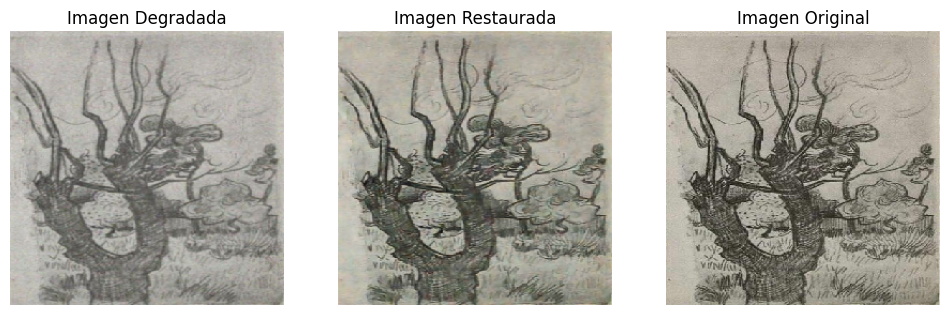

In [ ]:
# Evaluar el rendimiento en el conjunto de validación
loss, accuracy = model.evaluate(x_val, y_val)
print(f'Pérdida en el conjunto de validación: {loss:.4f}')
print(f'Precisión en el conjunto de validación: {accuracy:.4f}')

# Prueba con una imagen degradada aleatoria
import matplotlib.pyplot as plt

random_index = np.random.randint(0, len(x_val))
degraded_sample = x_val[random_index]
original_sample = y_val[random_index]

# Restaurar la imagen
restored_image = model.predict(np.expand_dims(degraded_sample, axis=0))[0]

# Mostrar las imágenes (Degradada, Restaurada, Original)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Imagen Degradada")
plt.imshow(degraded_sample)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Imagen Restaurada")
plt.imshow(restored_image)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Imagen Original")
plt.imshow(original_sample)
plt.axis('off')
plt.show()

## Probando con link


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


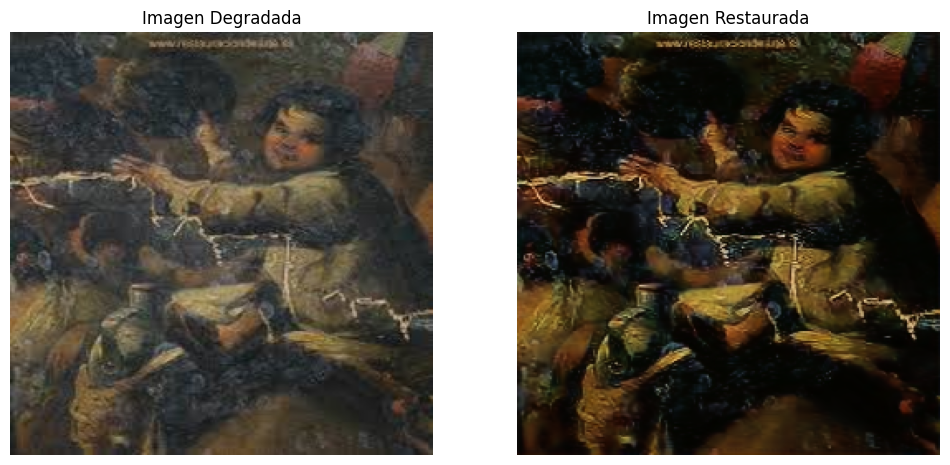

In [ ]:
import requests
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from io import BytesIO  # Importar BytesIO para manejar la imagen descargada

def download_image(url, target_size=(256, 256)):
    # Descargar la imagen de la URL
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))

    # Redimensionar la imagen al tamaño deseado
    image = image.resize(target_size)

    # Convertir la imagen a array de numpy y normalizar
    image_array = np.array(image) / 255.0  # Normalizar a [0, 1]

    return image_array

def preprocess_image(image_array):
    # Verificar si la imagen tiene 3 canales (RGB)
    if image_array.shape[-1] != 3:
        image_array = image_array[..., :3]

    # Añadir una dimensión para que tenga forma (1, height, width, 3)
    return np.expand_dims(image_array, axis=0)

def restore_image(model, degraded_image):
    # Restaurar la imagen usando el modelo
    restored_image = model.predict(degraded_image)[0]  # Obtener la primera imagen del lote

    # Escalar los píxeles a [0, 1]
    restored_image = np.clip(restored_image, 0, 1)

    return restored_image

# URL de la imagen que quieres probar
image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQJ21rrxp6Qq4Bd5MzEJOiU4QoJrR6SMmIbqw&s"  # Cambia esto por la URL de la imagen

# Paso 1: Descargar y preprocesar la imagen
degraded_image = download_image(image_url, target_size=(256, 256))
degraded_image_preprocessed = preprocess_image(degraded_image)

# Paso 2: Restaurar la imagen con el modelo entrenado
restored_image = restore_image(model, degraded_image_preprocessed)

# Paso 3: Mostrar las imágenes (Degradada y Restaurada)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Imagen Degradada")
plt.imshow(degraded_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Imagen Restaurada")
plt.imshow(restored_image)
plt.axis('off')

plt.show()

In [ ]:
model.save('RestorationModel_backup.keras')
print("Modelo guardado en formato .keras")

Modelo guardado en formato .keras


In [ ]:
import tensorflow as tf

# Convertir el modelo a formato TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Guardar el modelo TFLite en un archivo
with open('RestorationModel.tflite', 'wb') as f:
    f.write(tflite_model)

print("Modelo exportado a TensorFlow Lite (RestorationModel.tflite)")


Saved artifact at '/tmp/tmpap1x99bw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)
Captures:
  136758421816592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136758422037328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136758422205392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136758422193952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136758422307232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136758422314448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136758422314800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136758422317088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136758422318320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136758422320960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1367

In [ ]:
interpreter = tf.lite.Interpreter(model_path='RestorationModel.tflite', experimental_delegates=[])
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(f"Detalles de entrada: {input_details}")
print(f"Detalles de salida: {output_details}")

Detalles de entrada: [{'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([  1, 256, 256,   3], dtype=int32), 'shape_signature': array([ -1, 256, 256,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Detalles de salida: [{'name': 'StatefulPartitionedCall_1:0', 'index': 101, 'shape': array([  1, 256, 256,   3], dtype=int32), 'shape_signature': array([ -1, 256, 256,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
